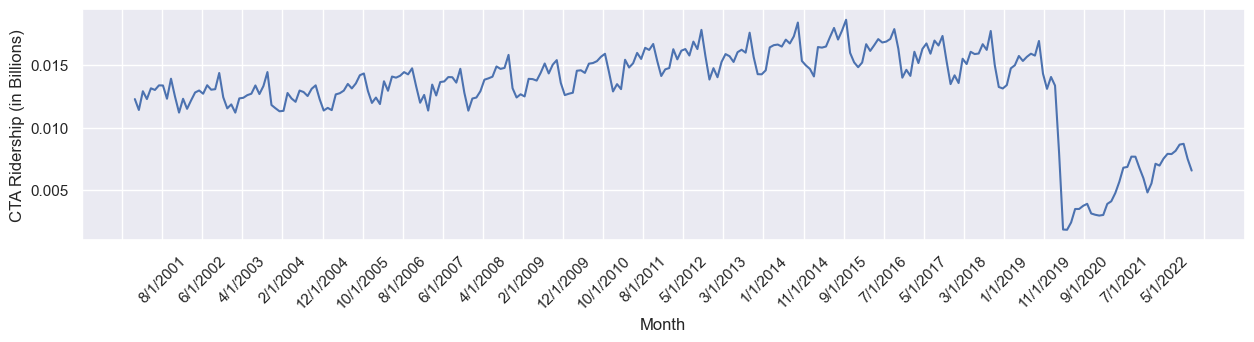

In [24]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns #for plotting
import pandas as pd #for data manipulation
import csv #to write csv files
import numpy as np #to create and manipulate arrays
import matplotlib.pyplot as plt #for data visual
import matplotlib.ticker as ticker #modify x axis ticks
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller 
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
from scipy.stats import t

#store and read the ridership dataset .csv file path 
csv_file = "C:\\Users\\rsa2227\\GitHub\\wgu\\capstone\\cta_univariate.csv"
cta_data = pd.read_csv(csv_file)
cta_data = cta_data.set_index('month')
cta_data.dropna(inplace=True) #drop NAs
cta_data = pd.DataFrame(cta_data)
# print(cta_data)

#plot realization 
plt.figure(figsize=(15,3))
plt.xlabel('Month')
plt.ylabel('CTA Ridership (in Billions)')
plt.xticks(rotation=45)
sns.set_theme(style='darkgrid')
cta_plot = sns.lineplot(x='month', y='monthtotal', data = cta_data)
cta_plot.xaxis.set_major_locator(ticker.LinearLocator(30))


1. ADF:  -1.6040882135114682
2. P-Value:  0.48153952517944687
3. Num of Lags:  13
4. Num of Obs Used for ADF Regression and Critical Values Calc:  250
5. Critical Values:  {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}
	 1% :  -3.456780859712
	 5% :  -2.8731715065600003
	 10% :  -2.572968544


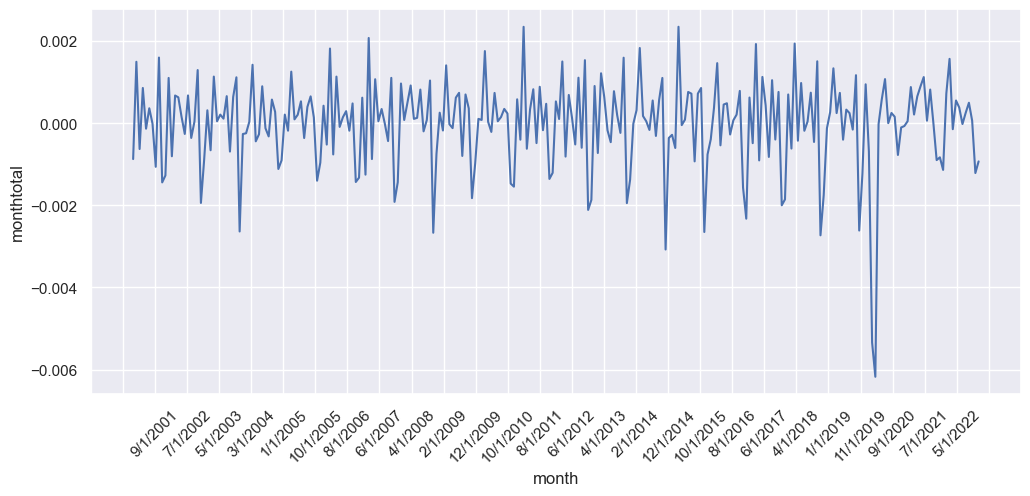

In [25]:
#evaluate stationarity with Dickey Fuller Test
def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF: ", dftest[0])
    print("2. P-Value: ", dftest[1])
    print("3. Num of Lags: ", dftest[2])
    print("4. Num of Obs Used for ADF Regression and Critical Values Calc: ", dftest[3])
    print("5. Critical Values: ", dftest[4])
    for key, val in dftest[4].items():
            print("\t", key, ": ", val)
ad_test(cta_data)

#apply differencing to make dataset stationary
diff_cta = cta_data.diff()
diff_cta = pd.DataFrame(diff_cta)
diff_cta.dropna(inplace=True) #drop NaNs

#plot dataset
fig, ax = plt.subplots(figsize=(12, 5))
diff_cta_plot = sns.lineplot(x='month', y='monthtotal', data=diff_cta, ax=ax)
plt.xticks(rotation=45)
diff_cta_plot.xaxis.set_major_locator(ticker.LinearLocator(30))



In [26]:
#split diff_cta to train and test dataset
train, test = train_test_split(diff_cta, test_size=.1, random_state=42)
train.to_csv("C:\\Users\\rsa2227\\GitHub\\wgu\\capstone\\train.csv")
test.to_csv("C:\\Users\\rsa2227\\GitHub\\wgu\\capstone\\test.csv")

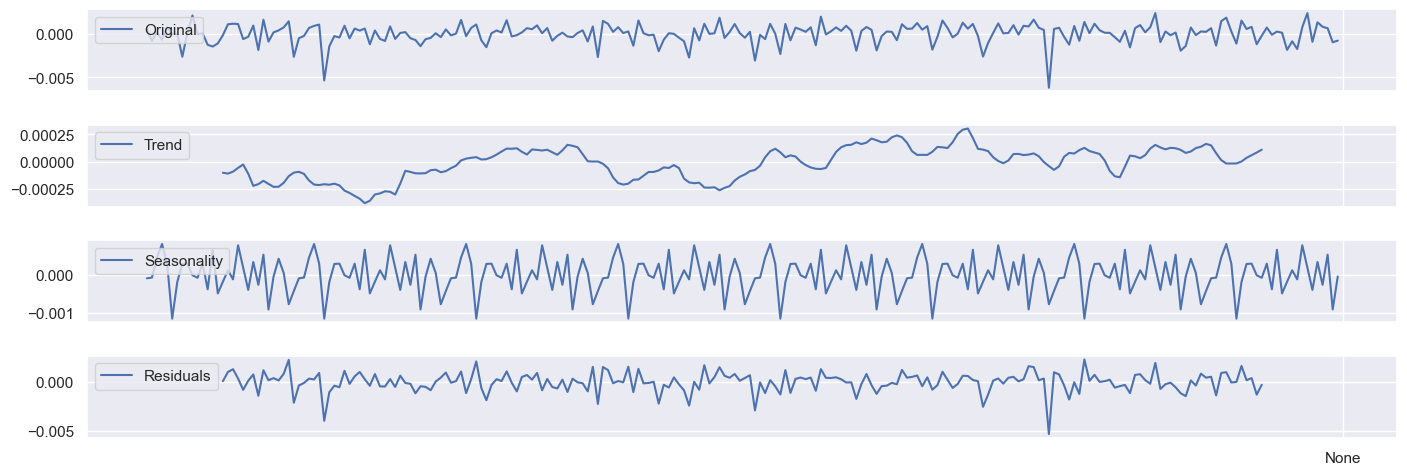

In [27]:
#model identification and analysis

#-------------------Decomposed Time Series---------------------

decomp = sm.tsa.seasonal_decompose(train, model='additive', period=30)
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(15)

axes[0].plot(train, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(decomp.trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(decomp.seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(decomp.resid, label='Residuals')
axes[3].legend(loc='upper left');
plt.xticks(ticks='None')

plt.show()
#--------------------------------------------------------


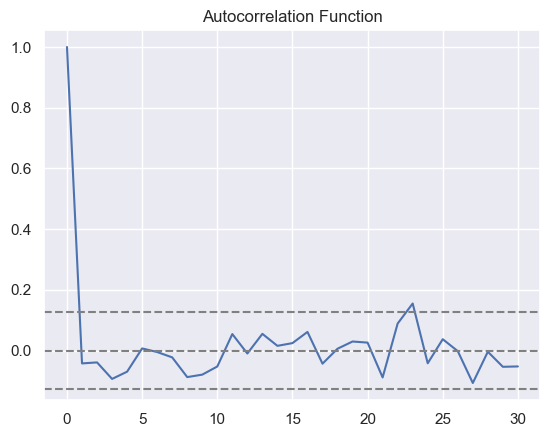

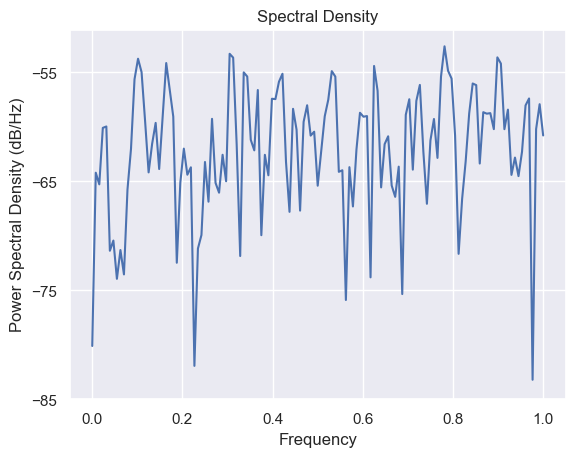

In [28]:
#-------------------Autocorrelation---------------------
acf = acf(train, nlags=30)
#plot autocorrelation
plt.plot(acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train)), linestyle='--', color='gray')
plt.axhline(y= 1.96/np.sqrt(len(train)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.show()
#--------------------------------------------------------

#-------------------Spectral Density---------------------
spec_density = plt.psd(train)
plt.title('Spectral Density')
plt.show()

#--------------------------------------------------------





In [29]:
#-----------------ARIMA----------------------
#find p,d,q values through auto arima, determine seasonality
stepwise_fit = auto_arima(train, trace=True, suppress_warnings=True)
stepwise_fit.summary()

# #run ARIMA on train set, best order ARIMA(0,0,0)
model= ARIMA(train,order=(0,0,0))
results_ARIMA = model.fit()
print(results_ARIMA.summary())
pred_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2530.815, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2535.144, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2533.566, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2533.606, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2537.086, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2531.143, Time=0.69 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 2.095 seconds
                               SARIMAX Results                                
Dep. Variable:             monthtotal   No. Observations:                  236
Model:                          ARIMA   Log Likelihood                1269.565
Date:                Fri, 28 Apr 2023   AIC                          -2535.130
Time:                        17:01:24   BIC                          -2528.202
Sample:                             0   HQIC                         -2532.337
    

In [30]:
#----------Predict-----------------
#convert to cumulative sum
pred = results_ARIMA.predict(start=len(train), end=(len(train)+len(test))-1).rename('ARIMA Predictions')


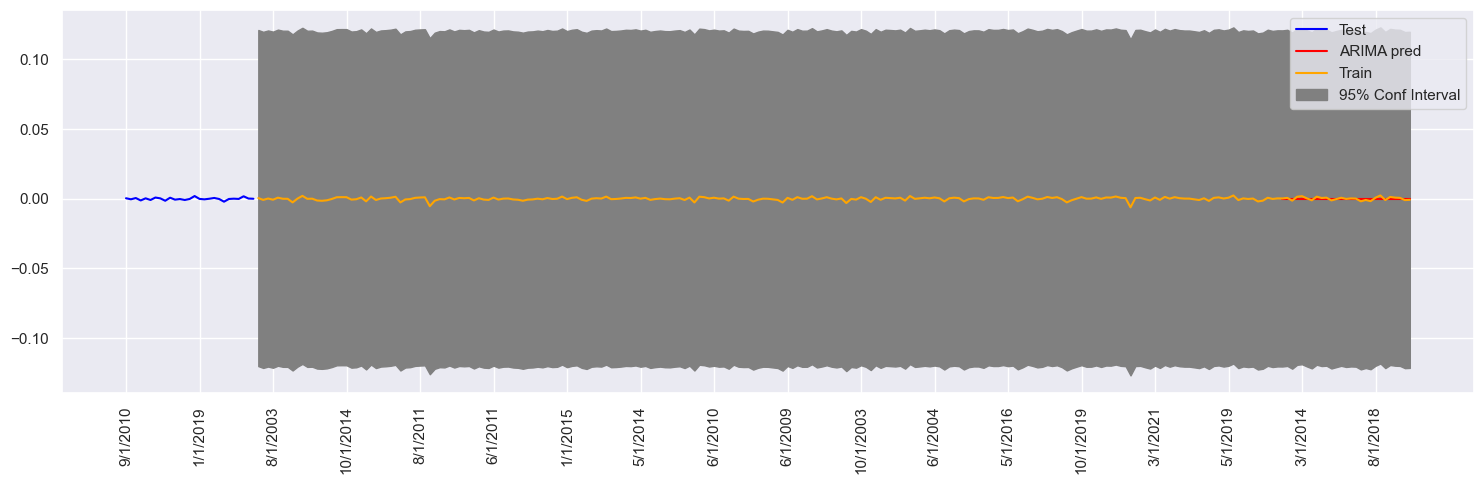

In [31]:
plt.figure(figsize=(15,5))
plt.plot(test, label='Test', color='blue')
plt.plot(pred, label='ARIMA pred', color='red')
plt.plot(train, label='Train', color='orange')
plt.legend()

ci = 1.96/np.sqrt(len(cta_data)) #get confidence interval

plt.xticks(np.arange(0,len(cta_data), 15), rotation='vertical')
plt.fill_between(train.index, (train['monthtotal']-ci), (train['monthtotal']+ci), color='gray', label='95% Conf Interval')
plt.legend(loc="upper right")

plt.tight_layout()

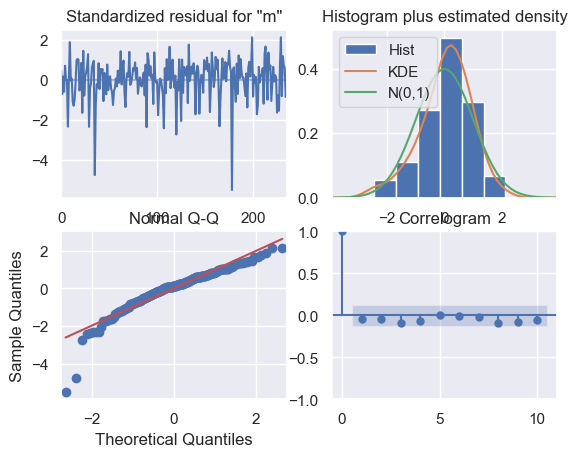

MAE Train: 0.000609
MAE Test: 0.000807


In [32]:
from sklearn.metrics import mean_absolute_error

#model evaluation
results_ARIMA.plot_diagnostics()
plt.show()

mae_train = mean_absolute_error(test,pred)
mae_test = mean_absolute_error(train, pred_ARIMA)
print('MAE Train: %f' % mae_train)
print('MAE Test: %f' % mae_test)
